In [ ]:
#importing all the libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

In [ ]:
df=pd.read_csv('Historical Product Demand.csv') #reading the dataset

In [ ]:
df=df.dropna() #dropping the null valued columns

In [ ]:
warehouseA = df.loc[df['Warehouse'] == 'Whse_A']   #selecting data for one warehouse

In [ ]:
warehouseA['Date']=pd.to_datetime(warehouseA['Date'])
warehouseA.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
34593,Product_0905,Whse_A,Category_023,2012-03-07,50
41029,Product_0097,Whse_A,Category_019,2012-01-18,6000
41030,Product_1496,Whse_A,Category_019,2012-03-13,5000
41031,Product_0097,Whse_A,Category_019,2012-04-16,6000
41032,Product_0097,Whse_A,Category_019,2012-09-24,3900


In [ ]:
cols = ['Product_Code', 'Warehouse', 'Product_Category'] #deleting columns which are not required
warehouseA.drop(cols, axis=1, inplace=True)
warehouseA.head()

,Date,Order_Demand
34593,2012-03-07,50
41029,2012-01-18,6000
41030,2012-03-13,5000
41031,2012-04-16,6000
41032,2012-09-24,3900


In [ ]:
# converting the order demand to float and then removing the negative values 
cols = ['Order_Demand']
warehouseA[cols] = warehouseA[cols].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
warehouseA=warehouseA.dropna()

In [ ]:
warehouseA = warehouseA.groupby('Date')['Order_Demand'].sum().reset_index()

In [ ]:
warehouseA.info()
warehouseA=warehouseA.dropna() #dropping null columns if any
warehouseA = warehouseA.set_index('Date') #setting date as the index column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1575 non-null   datetime64[ns]
 1   Order_Demand  1575 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 24.7 KB


In [ ]:
y = warehouseA['Order_Demand']  # creating the dataset for forecasting
y = y.sort_index(axis=0,ascending=True)
y.head()

Date
2011-01-08       2.0
2011-05-31     108.0
2011-11-18    4001.0
2011-11-21     110.0
2011-11-22    3700.0
Name: Order_Demand, dtype: float64

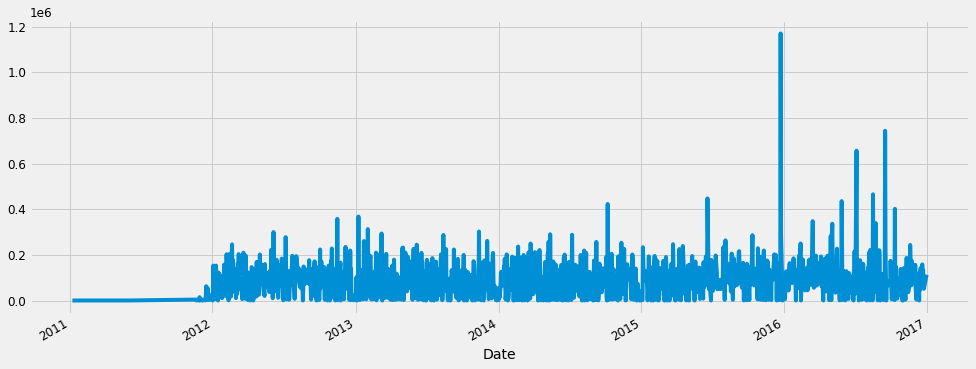

In [ ]:
y.plot(figsize=(15, 6)) #plotting data for visualisation 
plt.show()

In [ ]:
#creating the list of parameters to check for training the sarimax model
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Combinations for Seasonal ARIMA...')
print('SARIMAX {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX {} x {}'.format(pdq[1], seasonal_pdq[2]))

Combinations for Seasonal ARIMA...
SARIMAX (0, 0, 1) x (0, 0, 1, 12)
SARIMAX (0, 0, 1) x (0, 1, 0, 12)


In [ ]:
#training the sarimax model for all the paramter combinations 
for prm in pdq:
    for prmseason in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=prm,
                                            seasonal_order=prmseason,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(prm, prmseason, results.aic))
        except:
            continue

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

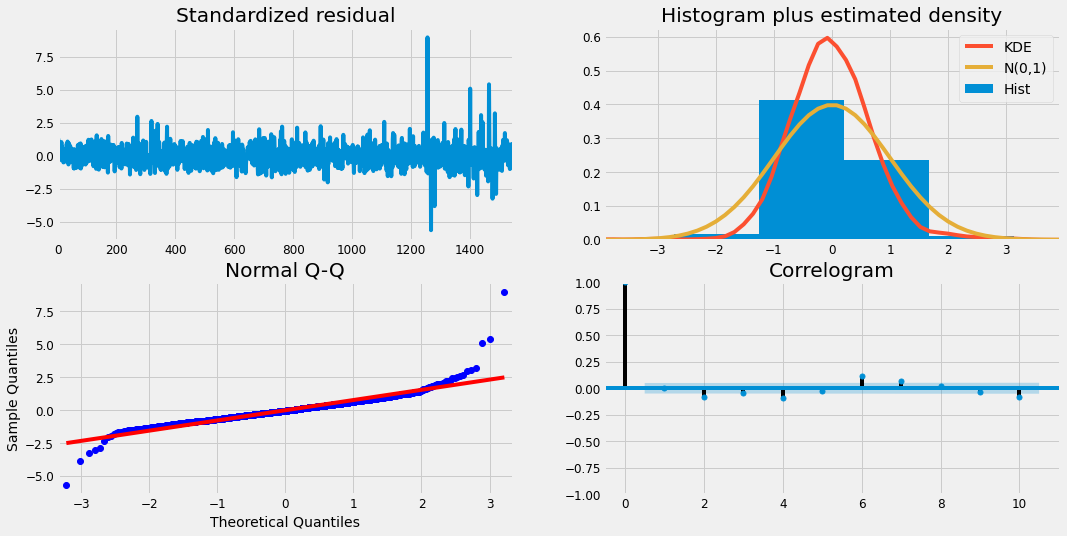

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

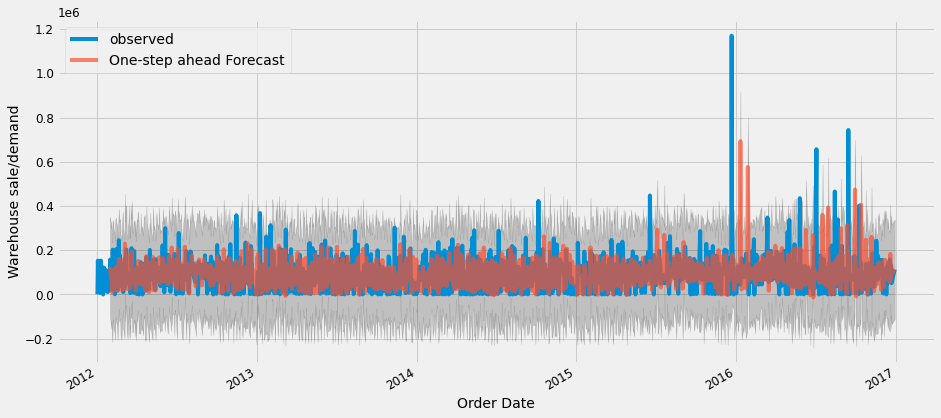

In [ ]:
preds = results.get_prediction(start=(52), dynamic=False) #getting the forecasts from the model
pred_ci = preds.conf_int()
ax = y['2012':].plot(label='observed')
preds.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Order Date')
ax.set_ylabel('Warehouse sale/demand')
plt.legend()
plt.show()

In [ ]:
#getting the list of predictions and then calculating the mse and rmse scores between the actual demands and the forecasted ones. 
y_forecasted = preds.predicted_mean
y_truth = y['2016-01-03':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE: {}'.format(round(mse, 2)))
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

MSE: 13398448065.56
RMSE: 115751.67


In [ ]:
y_forecasted #a sample of the forecasted demands

Date
2012-01-31    124188.324893
2012-02-01    100915.936703
2012-02-02     72952.321295
2012-02-03    104713.089706
2012-02-05     10110.962511
                  ...      
2016-12-20    183190.675243
2016-12-21     71414.395666
2016-12-22    131402.065320
2016-12-23     91222.853838
2016-12-30    113671.810913
Length: 1523, dtype: float64